In [53]:
import time

import random
import numpy as np
import matplotlib.pyplot as plt

import argparse

In [54]:
def read_data(data_path, show=False):
    """Read the specified data (KQBF problem)"""
    # data_path = "./instances/kqbf/kqbf020"

    with open(data_path, "r") as file:
        lines = file.readlines()

    N = int(lines[0].strip())
    W = int(lines[1].strip())
    w = list(map(int, lines[2].strip().split()))
    A = []

    for i in range(N):
        row = list(map(int, lines[i + 3].strip().split()))
        A.append(row)

    max_length = max(len(sublist) for sublist in A)
    for sublist in A:
        sublist.extend([0] * (max_length - len(sublist)))

    matrix = np.zeros((max_length, max_length))
    for i in range(max_length):
        for j in range(i + 1):
            matrix[i][j] = A[i][j]
            matrix[j][i] = A[i][j]

    if show:
        print("N:", N)
        print("W:", W)
        print("w:", w)
        print("A:")
        for row in A:
            print(row)

    return N, W, np.array(w), np.array(matrix)

In [81]:
# Definindo a função objetivo QBF
def objective_function(x, A):
    return np.dot(x, np.dot(A, x.T))

# Definindo a restrição do problema
def constraint(x, w, W, show=False):
    result = np.dot(x, w)
    if show:
        print(f"<x|w> <= W?")
        print(f"<{x}|{w}> = {result} \n    <= {W}??? {result <= W}")
    return result <= W

def initialize_population(population_size, n):

    population = []
    for _ in range(population_size):

        x = np.random.randint(2, size=n)
        population.append(x)

    return population

'''from pyDOE import lhs

def initialize_population_lhs(population_size, n):
    # LHS gera amostras no intervalo [0, 1], então ajustamos para [0, 1, ..., n_genes-1] para cada gene
    population = lhs(n, samples=population_size, criterion='maximin')
    
    # Para um problema binário, você pode querer converter esses valores para 0 ou 1.
    # Aqui, estamos assumindo um cenário onde cada gene tem um intervalo [0, 1, ..., n_genes-1].
    # Ajuste essa parte conforme necessário para o seu problema específico.
    population = np.round(population * (n - 1)).astype(int)
    
    # Convertendo para uma lista de arrays numpy
    population_list = [np.array(individual) for individual in population]
    
    return population_list'''

def lhs_sample(n, dims):
    """
    Generate Latin Hypercube Samples (LHS) for given dimensions and number of samples.

    Parameters:
    n (int): Number of samples.
    dims (int): Number of dimensions.

    Returns:
    np.ndarray: Latin Hypercube Samples.
    """
    # Inicializa o array de amostras
    lhs_samples = np.empty((n, dims))

    # Divide o intervalo em n partes iguais e escolhe um valor em cada intervalo
    for i in range(dims):
        lhs_samples[:, i] = np.random.uniform(size=n)

    # Embaralha as amostras em cada dimensão
    for i in range(dims):
        np.random.shuffle(lhs_samples[:, i])

    return lhs_samples

def initialize_population_lhs(population_size, n):
    """
    Initialize the population using Latin Hypercube Sampling.

    Parameters:
    population_size (int): Size of the population.
    n (int): Number of dimensions.

    Returns:
    list: Initial population using Latin Hypercube Sampling.
    """
    population = []
    lhs_samples = lhs_sample(population_size, n)  # Gerar várias amostras LHS
    for sample in lhs_samples:
        x = (sample > 0.5).astype(int)  # Convertendo valores em binário
        population.append(np.array(x))  # Convertendo para numpy array
    return population

def stochastic_universal_selection(population, fitness_values, n_parents):
    # Calcula a soma total das pontuações de fitness
    total_fitness = sum(fitness_values)
    
    # Calcula a distância entre cada segmento
    segment_distances = total_fitness / n_parents if total_fitness != 0 else 1
    
    # Gera um ponto de partida aleatório dentro do primeiro segmento
    start_point = np.random.uniform(0, segment_distances)
    
    # Inicializa os índices dos pais selecionados
    selected_parents = []
    
    # Inicializa o ponto de partida para a seleção
    selected_point = start_point

    # Seleciona os pais
    while len(selected_parents) < n_parents:
        # Percorre a população para encontrar o indivíduo correspondente ao ponto selecionado
        cumulative_fitness = 0
        prev_len = len(selected_parents)
        for idx, ind_fitness in enumerate(fitness_values):
            cumulative_fitness += ind_fitness
            # Se a soma cumulativa das pontuações de fitness for maior que o ponto selecionado,
            # adiciona o indivíduo correspondente à lista de pais selecionados
            # print("selected_point:", selected_point)
            # print("......cumulative_fitness", cumulative_fitness)
            if cumulative_fitness > selected_point:
                selected_parents.append(population[idx])
                # Atualiza o ponto selecionado para o próximo segmento
                selected_point += segment_distances
                break

        print("len(selected_parents)", len(selected_parents))

        # If no parent was selected in this iteration, select a random parent
        if len(selected_parents) == prev_len:
            selected_parents.append(random.choice(population))

            print("add random parent from population...")
    
    return selected_parents

def uniform_crossover(parent1, parent2):
    # Inicializa o filho com o mesmo formato que os pais
    child = np.empty_like(parent1)
    
    # Realiza o cruzamento
    for i in range(len(parent1)):
        # Seleciona aleatoriamente o gene do pai 1 ou pai 2 para o filho
        if np.random.rand() < 0.5:  # 50% de chance de selecionar o gene do pai 1
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    
    return child

def mutation(bitstring, mutation_rate):
	for i in range(len(bitstring)):
		# check for a mutation
		if np.random.rand() < mutation_rate:
			# flip the bit
			bitstring[i] = 1 - bitstring[i]

In [71]:
def genetic_algorithm(population_size, 
                      number_generation, 
                      A, w, W, 
                      lhs_inicialization=False,
                      su_selection=False,
                      unif_crossover=False,
                      dynamic_mutation=True,
                      mutation_rate=.6):

    # Initialization

    n = len(w)
    if lhs_inicialization:
        population = initialize_population_lhs(population_size, n)
    else:
        population = initialize_population(population_size, n) 
    fitness_history = []

    best_solution = None
    best_fitness = float("-inf")

    #print("population:")
    #display(population)

    for generation in range(number_generation):

        # Evaluation
        fitness = [objective_function(x, A) for x in population]
        #print(fitness)
        # fitness = []
        # for x in population:
        #     print("x", x, "dim", x.shape)
        #     print("A", A, "dim", A.shape)
        #     fitness.append(objective_function(x, A))

        feasible_population = [x for x in population if constraint(x, w, W)]

        # print(f"feasible population for generation {generation}")
        # display(feasible_population)
        
        # Selection 

        if feasible_population:

            feasible_fitness = [objective_function(x, A) for x in feasible_population]
            # Selecting parents with the highest feasible fitness
            if su_selection:
                parents = stochastic_universal_selection(population, feasible_fitness, population_size)
            else:
                parents = random.choices(feasible_population, weights=feasible_fitness, k=population_size)
            
        else:

            parents = []
            while len(parents) < population_size:
                # Restart the initial population until we find a feasible solution
                if lhs_inicialization:
                    adjusted_population = initialize_population_lhs(population_size, n)
                else:
                    adjusted_population = initialize_population(population_size, n)
                if any(weight > 0 for weight in fitness):
                    if su_selection:
                        potential_parents = stochastic_universal_selection(adjusted_population, fitness, population_size)
                    else:
                        potential_parents = random.choices(adjusted_population, weights=fitness)
                    
                else:
                    potential_parents = random.choices(adjusted_population)

                try:
                    if constraint(potential_parents, w, W):
                        parents.append(potential_parents)
                except:
                    continue

        # print(f"parents for generation {generation}")
        # display(parents)

        # Crossover/Recombination (Offspring)
                
        # offspring = []
        # for i in range(population_size):

        #     parent1, parent2 = random.choices(parents, k=2)
        #     child = np.array([random.choice([bit1, bit2]) for bit1, bit2 in zip(parent1, parent2)])

        #     offspring.append(child)
                
        offspring = []
        for _ in range(population_size):
            
            parent1, parent2 = random.sample(parents, 2)  # Use random.sample instead of random.choices

            # print(">>>>>>>>>>>>>>>>>>>>>>>>>")
            # print("p1, p2:", parent1, parent2)
            # print()
            
            if unif_crossover:
                child = uniform_crossover(parent1, parent2)
            else:
                child = np.array([random.choice([bit1, bit2]) for bit1, bit2 in zip(parent1, parent2)])
            

            offspring.append(child)
        
        # print(">>>>>>>>>>>>>>>>>>>>>>>>>")
        # print(f"offspring for generation {generation}: {offspring}")
        # print(">>>>>>>>>>>>>>>>>>>>>>>>>")
        # print()

        # Mutation
            
        # mutation_rate = 1 / (generation + 1) # Dynamic mutation rate
        # for i in range(population_size):

        #     if random.random() < mutation_rate:
        #         offspring[i] = np.random.randint(2, size=len(offspring[i]))


        # Mutation
        if dynamic_mutation == True:
            dynamic_mutation_rate = 1 / (generation + 1) # Dynamic mutation rate
            for i in range(population_size):

                if random.random() < dynamic_mutation_rate:

                    mutation_index = random.randint(0, len(offspring[i])-1)
                    offspring[i][mutation_index] = 1 - offspring[i][mutation_index]  # Flip the bit at the mutation_index
        else:
            for i in range(population_size):
                mutation(offspring[i], mutation_rate)
    
        # Elitism
        if best_solution is not None:
            offspring[0] = best_solution # Best solution is preserved in next generation

        population = offspring

        # print(">>>>>>>>>>>>>>>>>>>>>>>>>")
        # print(f"population for generation {generation}:")
        # display(population)
        # print(">>>>>>>>>>>>>>>>>>>>>>>>>")

        # Find the best feasible solution
        feasible_solutions = [x for x in population if constraint(x, w, W)]
        # feasible_solutions = []
        # for x in population:
        #     print("x", x, "dim", x.shape)
        #     if constraint(x, w, W):
        #         feasible_solutions.append(x)

        if feasible_solutions:

            best_solution = max(feasible_solutions, key=lambda x: objective_function(x, A))
            # try:
            best_fitness = objective_function(best_solution, A)
            # except:
            #     best_fitness = float(np.sum(objective_function(best_solution, A)))

            try:
                best_fitness = float(np.sum(objective_function(best_solution, A)))
            except:
                pass

        # if best_fitness is not None:  # Only add scalar values to fitness_history

        #     fitness_history.append(best_fitness)
                
        #print("best fitness", best_fitness)

        fitness_history.append(best_fitness)

    # Plot fitness progress
    plt.plot(range(1, number_generation+1), fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Genetic Algorithm - Fitness progress")
    plt.show()

    return best_solution, best_fitness


[12 16  4  2 11 14  2 15  6  2  8  2 14 16 11 14 10  0 20 14]
64

len(selected_parents) 1
len(selected_parents) 2
len(selected_parents) 3
len(selected_parents) 4
len(selected_parents) 5
len(selected_parents) 6
len(selected_parents) 7
len(selected_parents) 8
len(selected_parents) 9
len(selected_parents) 10
len(selected_parents) 11
len(selected_parents) 12
len(selected_parents) 13
len(selected_parents) 14
len(selected_parents) 15
len(selected_parents) 16
len(selected_parents) 17
len(selected_parents) 18
len(selected_parents) 19
len(selected_parents) 20
len(selected_parents) 21
len(selected_parents) 22
len(selected_parents) 23
len(selected_parents) 24
len(selected_parents) 25
len(selected_parents) 26
len(selected_parents) 27
len(selected_parents) 28
len(selected_parents) 29
len(selected_parents) 30
len(selected_parents) 31
len(selected_parents) 32
len(selected_parents) 33
len(selected_parents) 34
len(selected_parents) 35
len(selected_parents) 36
len(selected_parents) 37
len(selected_paren

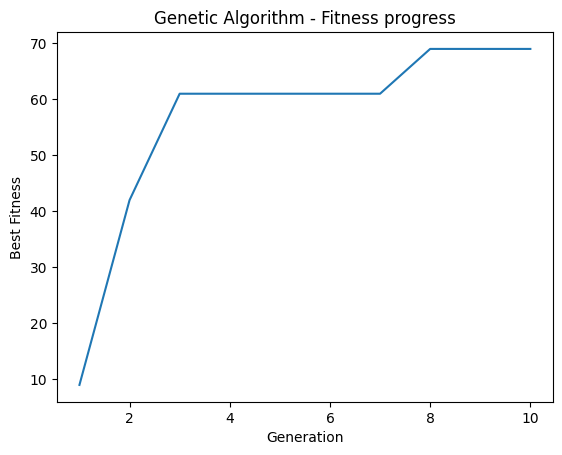

[1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0] 69.0


In [82]:
problem_instance = "kqbf020" # args.problem_instance
N, W, w, A = read_data(data_path=f"./instances/kqbf/{problem_instance}", show=False)
w = np.array(w)

print(w)
print(W)
print()

# Aplicando o algoritmo genético
best_solution, best_fitness = genetic_algorithm(50, 10, 
                                                A, w, W, 
                                                lhs_inicialization=False,
                                                su_selection=True,
                                                unif_crossover=False,
                                                dynamic_mutation=False,
                                                mutation_rate=.6)

print(best_solution, best_fitness)

In [61]:
constraint(best_solution, w, W, show=True)

<x|w> <= W?
<[[0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0]]|[12 16  4  2 11 14  2 15  6  2  8  2 14 16 11 14 10  0 20 14]> = [51] 
    <= 64??? [ True]


array([ True])